# Lane Finding Protyping and Testing

* Notes: In this notebook, the **src** and **dst** for persepctive transform is different from the defined in LaneFinding class 

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from itertools import permutations 
import pickle

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from LaneFinding import LaneFinding
import os

In [2]:
lane_finding = LaneFinding("calibration.pickle")

# 2. Use color transforms, gradients, etc., to create a thresholded binary image.

In [3]:
def plot_images(images_list, columns=3, rows=3, is_binary=True, figsize=(16, 10)):
    """
    """
    fig=plt.figure(figsize=figsize)
    for i,img in enumerate(images_list):
        fig.add_subplot(rows, columns, i+1)
        binary = None
        if not is_binary and len(img[0].shape) <= 2:
            binary = np.zeros_like(img[0])
            binary[(img[0] > thresh[0]) & (img[0] <= thresh[1])] = 1
            
        if is_binary:
            plt.imshow(img[0], cmap="gray")
        elif binary is not None:
            plt.imshow(binary, cmap="gray")
        else:
            plt.imshow(img[0])
        plt.title(img[1], fontsize=16)
    plt.show()

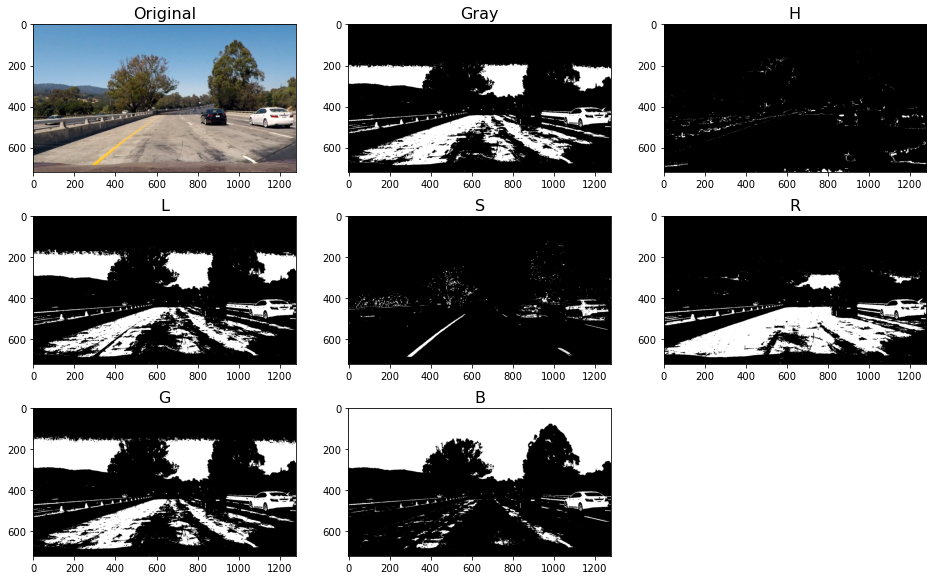

In [4]:
image = mpimg.imread("test_images/test1.jpg")
thresh = (170, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

images_list = [
    [image, "Original"],
    [gray, "Gray"],
    [H, "H"],
    [L, "L"],
    [S, "S"],
    [R, "R"],
    [G, "G"],
    [B, "B"],
]

plot_images(images_list,is_binary=False)

In [5]:
%%time
# This is for choosing the best permutation
# selections = ["GR", "H", "L", "S","R","G","B"]
# perm = permutations(selections, 2) 
# image = mpimg.imread("test_images/test1.jpg")
# perm = list(perm)
# for s in selections:
#     perm.append((s,s))
# for i,p in enumerate(list(perm)):  
#     result = binarize_image(image, selections=[p[0],p[1]]) 
#     plt.imsave(f"debug/{p[0]}_{p[1]}.jpg",result, cmap="gray")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


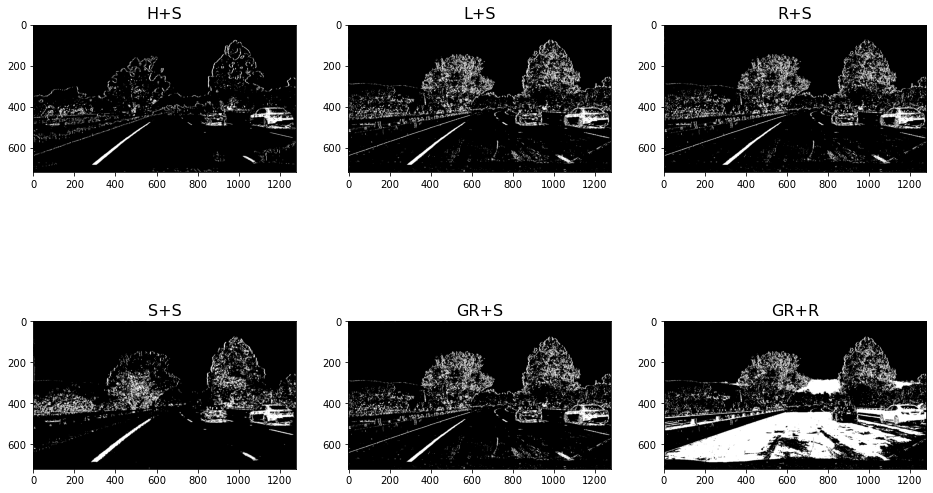

In [6]:
best_selection = [
    ["H","S"],
    ["L","S"],
    ["R","S"],
    ["S","S"],
    ["GR","S"],
    ["GR","R"],
]

images_list = []
for b in best_selection:
    result = lane_finding.binarize_image(image, selections=[b[0],b[1]])
    images_list.append(
        [result.copy(), f"{b[0]}+{b[1]}"]
    )
plot_images(images_list, rows=2)

# 4. Apply a perspective transform to rectify binary image ("birds-eye view").

### Search for the right src and dst for persepctive transform

In [7]:
# Gradient data
#avgs = np.array([np.array([-7.86183119e-01,  9.24773005e+02]), np.array([ 0.53300304, 84.69663826])])
# straight line
avgs = np.array([np.array([-7.11205139e-01,  8.72276644e+02]), np.array([ 0.62472951, 23.40836178])])
topy = 460
img_height = 720
vertices = np.array([[
    [int((avgs[0][1] - img_height) / -avgs[0][0]), int(img_height)],
    [int((avgs[0][1] - topy) / -avgs[0][0]), int(topy)],
    [int((avgs[1][1] - topy) / -avgs[1][0]), int(topy)],
    [int((avgs[1][1] - img_height) / -avgs[1][0]), int(img_height)],
]], dtype=np.int32)

In [8]:
# to get new y intercept
# c0 = 720 - avgs[0][0] * (170)
# c1 = 720 - avgs[1][0] * (1170)
# vertices = np.array([[
#     [int((c0 - img_height) / -avgs[0][0]), int(img_height)],
#     [int((c0 - topy) / -avgs[0][0]), int(topy)],
#     [int((c1 - topy) / -avgs[1][0]), int(topy)],
#     [int((c1 - img_height) / -avgs[1][0]), int(img_height)],
# ]], dtype=np.int32)

In [9]:
vertices

array([[[ 214,  720],
        [ 579,  460],
        [ 698,  460],
        [1115,  720]]], dtype=int32)

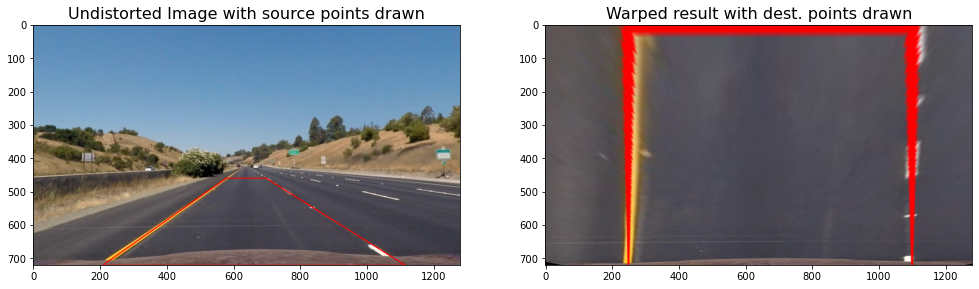

In [4]:
image = mpimg.imread("test_images/straight_lines1.jpg")
vertices = np.array([[
             [209,  720],  # Bottom left
             [579,    460],  # Top left
             [698,   460],  # Top right
             [1115, 720] # Bottom right
        ]], dtype=np.int32)
src = vertices.reshape([4,2]).astype('float32')
dst = np.float32([
             [250,  720],  # Bottom left
             [250,    0],  # Top left
             [1100,   0],  # Top right
             [1100, 720] # Bottom right
    ])
#image = mpimg.imread("test_images/test1.jpg")
#image = mpimg.imread("debug/video_540.jpg")
image = lane_finding.undistort(image)
imshape = image.shape
cv2.polylines(image,vertices,True,(255,0,0), 2)
warped, M_inv = lane_finding.warp_perspective(image, src,dst)
images_list = [
    [image.copy(), "Undistorted Image with source points drawn"],
    [warped, "Warped result with dest. points drawn"]
]

plot_images(images_list,is_binary=False, rows=1, figsize=(26, 10))

# 5. Detect lane pixels and fit to find the lane boundary.

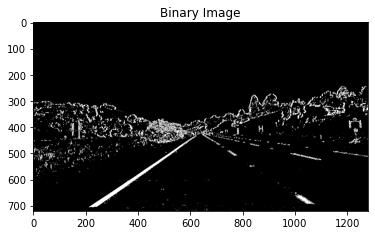

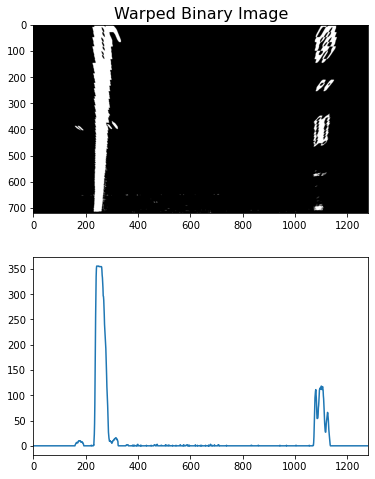

In [36]:
input_image = mpimg.imread("test_images/straight_lines1.jpg")
input_image = lane_finding.undistort(input_image)
binary_image = lane_finding.binarize_image(input_image, selections=["L","S"])
plt.imshow(binary_image,cmap='gray')
plt.title("Binary Image")
warped_binary, Minv = lane_finding.warp_perspective(binary_image, src, dst)

# Create histogram of image binary activations
histogram = lane_finding.hist(warped_binary)

fig=plt.figure(figsize=(6, 8))
fig.add_subplot(2, 1, 1)
plt.imshow(warped_binary, cmap="gray")
plt.title("Warped Binary Image", fontsize=16)
fig.add_subplot(2, 1, 2)
plt.plot(histogram)
plt.margins(x=0)
plt.show()

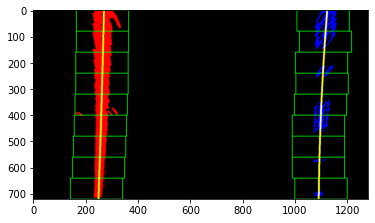

In [37]:
leftx, lefty, rightx, righty, out_img, rects = lane_finding.find_lane_pixels(warped_binary)
left_fitx, right_fitx, ploty, left_fit,right_fit = lane_finding.fit_polynomial(
    out_img, leftx, lefty, rightx, righty
)
out_img = lane_finding.draw_search_sliding(
    out_img, rects, ploty, leftx, lefty, rightx, righty,left_fitx, right_fitx 
)
plt.imshow(out_img)
plt.show()

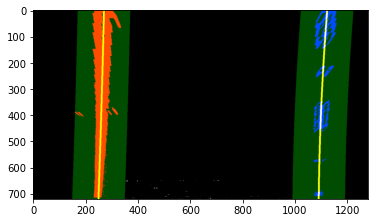

In [39]:
leftx, lefty, rightx, righty, out_img = lane_finding.search_around_poly(warped_binary, left_fit, right_fit)
left_fitx, right_fitx, ploty, left_fit,right_fit = lane_finding.fit_polynomial(out_img, leftx, lefty, rightx, righty)
result = lane_finding.draw_search_poly(out_img, ploty, leftx, lefty, rightx, righty,left_fitx, right_fitx)
# View your output
plt.imshow(result)
plt.show()

# 6. Determine the curvature of the lane and vehicle position with respect to center.

In [42]:
# the per pix can be modified like so
lane_finding.ym_per_pix=30/720
lane_finding.xm_per_pix=3.7/830

left_curverad, right_curverad = lane_finding.get_curvature_radius(ploty,left_fitx, right_fitx)
print(f"Left lane line curvature: {round(left_curverad,2)} m")
print(f"Right lane line curvature: {round(right_curverad,2)} m")

Left lane line curvature: 20500.11 m
Right lane line curvature: 4029.6 m


In [44]:
pos = lane_finding.get_vehicle_position(image.shape,left_fitx, right_fitx)
print(f"Vehicle position with respect to center : {round(pos,2)} m")

Vehicle position with respect to center : -0.14 m


# Warp the detected lane boundaries back onto the original image.

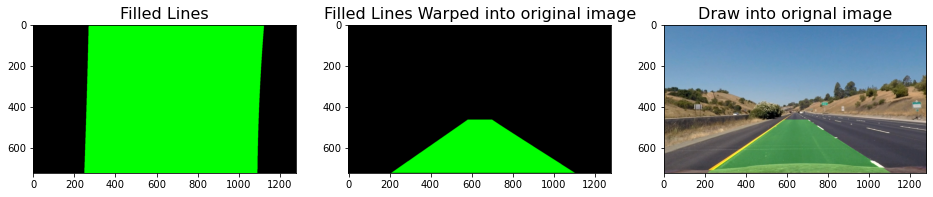

In [45]:
images_list = []
# create a blank color warped
warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# And recast the x and y points into usable format for cv2.fillPoly()
left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
line_pts = np.hstack((left_line, right_line))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([line_pts]), (0,255, 0))
images_list.append([color_warp.copy(), "Filled Lines"])
# Warp to original image
new_warp = cv2.warpPerspective(color_warp, M_inv, (input_image.shape[1], input_image.shape[0])) 
images_list.append([new_warp.copy(), "Filled Lines Warped into original image"])
result = cv2.addWeighted(input_image, 1, new_warp, 0.3, 0)
images_list.append([result.copy(), "Draw into orignal image"])
plot_images(images_list,is_binary=False, rows=1, columns=3)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

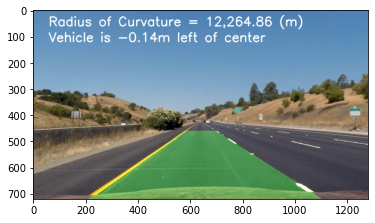

In [47]:
curverad = (left_curverad + right_curverad) / 2
labelled_img = lane_finding.add_num_estimation(result,curverad, pos)
plt.imshow(labelled_img)
plt.show()

# Run the Pipeline on test images

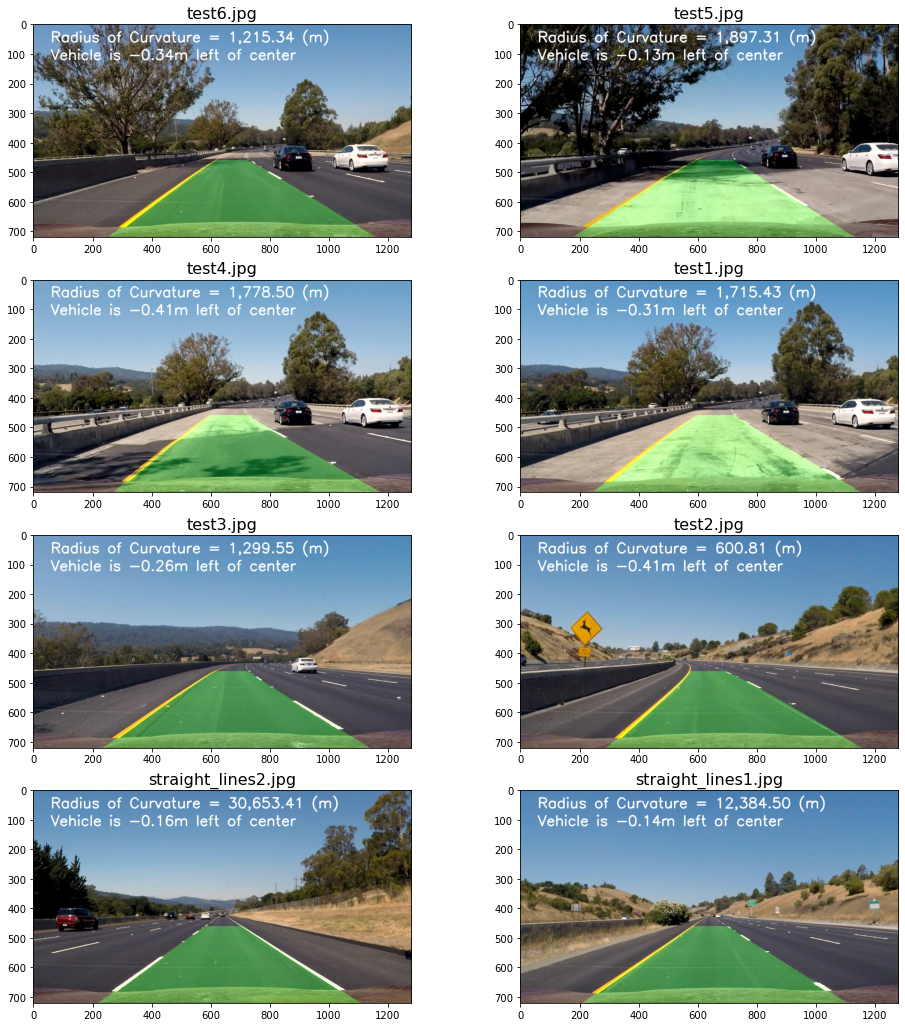

In [65]:
test_image_dir = "test_images"
output_image_dir = "output_images"
files = os.listdir(test_image_dir)
images_list = []

for i,file in enumerate(files):
    input_image = mpimg.imread(os.path.join(test_image_dir,file))
    color_conversion = cv2.COLOR_BGR2RGB
    # disable debug
    lane_finding.is_debug = False
    # reset
    lane_finding.reset()
    # undistort
    undistort_img = lane_finding.undistort(input_image)
    cv2.imwrite(
        os.path.join(output_image_dir,"undistort_"+file), 
        cv2.cvtColor(undistort_img,color_conversion)
    )                          
    # convert to binary from gradient and color selection
    binary_image = lane_finding.binarize_image(undistort_img)
    mpimg.imsave(
        os.path.join(output_image_dir,"binary_"+file), 
        binary_image,
        cmap="gray"
    )                            
    # warp the image perspective
    warped_binary, M_inv = lane_finding.warp_perspective(binary_image, src, dst)
    mpimg.imsave(
        os.path.join(output_image_dir,"warp_binary_"+file), 
        warped_binary,
        cmap="gray"
    ) 
    # find the lines
    leftx, lefty, rightx, righty, out_img, rects = lane_finding.find_lane_pixels(warped_binary)                           
    # fit the lines
    left_fitx, right_fitx, ploty, left_fit, right_fit = lane_finding.fit_polynomial(out_img, leftx, lefty, rightx,righty)
    out_img = lane_finding.draw_search_sliding(
        out_img,rects, ploty, leftx, lefty, rightx, righty,left_fitx, right_fitx 
    )
    cv2.imwrite(
        os.path.join(output_image_dir,"lines_drawn_"+file), 
        cv2.cvtColor(out_img,color_conversion)
    ) 
    # measure the curvature
    left_curverad, right_curverad = lane_finding.get_curvature_radius(ploty, left_fitx, right_fitx)
    # measure the relative position to center
    pos = lane_finding.get_vehicle_position(warped_binary.shape, left_fitx, right_fitx)
    # unwarp and draw the lines
    output_image = lane_finding.unwarp(input_image, warped_binary, M_inv, left_fitx, right_fitx, ploty)
    cv2.imwrite(
        os.path.join(output_image_dir,"unwarp_"+file), 
        cv2.cvtColor(output_image,color_conversion)
    )                            
    # add the metrices into the final image
    curverad = (left_curverad + right_curverad) / 2
    output_image = lane_finding.add_num_estimation(output_image, curverad, pos)
    cv2.imwrite(
        os.path.join(output_image_dir,"final_"+file), 
        cv2.cvtColor(output_image,color_conversion)
    )
    images_list.append([output_image,file])

plot_images(images_list,rows=4, columns=2,is_binary=False, figsize=(16,18))

# Run the pipeline on project video

### sample video

In [7]:
video_sample_output = 'project_video_sample_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4").subclip(25,35)
lane_finding.reset()
lane_finding.is_debug = True
lane_finding.debug_frames = [132,146]
lane_finding.src = src
lane_finding.dst = dst
project_clip = clip.fl_image(lane_finding.video_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_sample_output, audio=False)

t:   1%|          | 3/250 [00:00<00:11, 21.01it/s, now=None]

Moviepy - Building video project_video_sample_output.mp4.
Moviepy - Writing video project_video_sample_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_sample_output.mp4
CPU times: user 22.8 s, sys: 3.78 s, total: 26.6 s
Wall time: 17.5 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_sample_output))

### Full video

In [5]:
video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
lane_finding.reset()
lane_finding.is_debug = False
lane_finding.src = src
lane_finding.dst = dst
project_clip = clip.fl_image(lane_finding.video_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_output, audio=False)

t:   0%|          | 3/1260 [00:00<01:07, 18.54it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 1min 50s, sys: 19.5 s, total: 2min 10s
Wall time: 1min 24s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

# Debug

In [7]:
import pandas as pd
import seaborn as sns

### How many time the search from scratch take over

In [11]:
lane_finding.num_search_scratch, lane_finding.num_search_scratch/lane_finding.nframe

(476, 0.3774781919111816)

### Avg Lane width

In [12]:
np.mean(lane_finding.lane_width)

858.6094343349894

In [15]:
lane_widths = []
for i in range(len(lane_finding.right_fitx)):
    lane_widths.append(np.array([lane_finding.right_fitx[i]-lane_finding.left_fitx[i]]).mean())

In [16]:
lane_width_df = pd.DataFrame(lane_finding.lane_width)

In [17]:
lane_width_df.describe()

,0
count,1261.000000
mean,858.609434
std,34.337022
min,751.166274
25%,833.234968
50%,853.872196
75%,878.458006
max,1006.188152


### Outliers in lane width

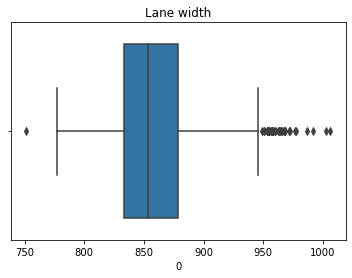

In [18]:
ax = sns.boxplot(x=lane_width_df[0])
ax.set_title('Lane width')
plt.show()

In [19]:
Q1 = lane_width_df[0].quantile(0.25)
Q3 = lane_width_df[0].quantile(0.75)
IQR = Q3 - Q1
print("Lane width should >= ", Q1 - 1.5 * IQR, " and <= ", Q3 + 1.5 * IQR)

Lane width should >=  765.4004120606103  and <=  946.2925620996878


In [20]:
lane_width_df[lane_width_df[0]>=918.8526876106025].shape

(73, 1)

In [21]:
lane_width_df.shape

(1261, 1)

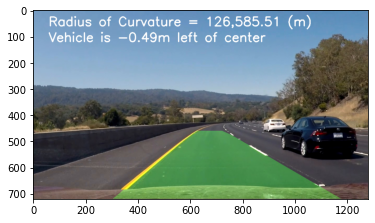

In [11]:
#anomaly
input_image = mpimg.imread("writeup_images/frame_132.jpg")
#input_image = mpimg.imread("debug/video_132.jpg")
lane_finding.is_debug = False
lane_finding.reset()
undistort_img = lane_finding.undistort(input_image)
binary_image = lane_finding.binarize_image(undistort_img, selections=["L","S"])
warped_binary, M_inv = lane_finding.warp_perspective(binary_image, src, dst)
leftx, lefty, rightx, righty, out_img, rects = lane_finding.find_lane_pixels(warped_binary)
left_fitx, right_fitx, ploty, left_fit, right_fit = lane_finding.fit_polynomial(out_img, leftx, lefty, rightx,righty)
left_curverad, right_curverad = lane_finding.get_curvature_radius(ploty, left_fitx, right_fitx)
pos = lane_finding.get_vehicle_position(warped_binary.shape, left_fitx, right_fitx)
output_image = lane_finding.unwarp(input_image, warped_binary, M_inv, left_fitx, right_fitx, ploty)
curverad = (left_curverad + right_curverad) / 2
output_image = lane_finding.add_num_estimation(output_image, curverad, pos)
plt.imshow(output_image)
mpimg.imsave("writeup_images/anomaly_1.jpg",output_image)
plt.show()

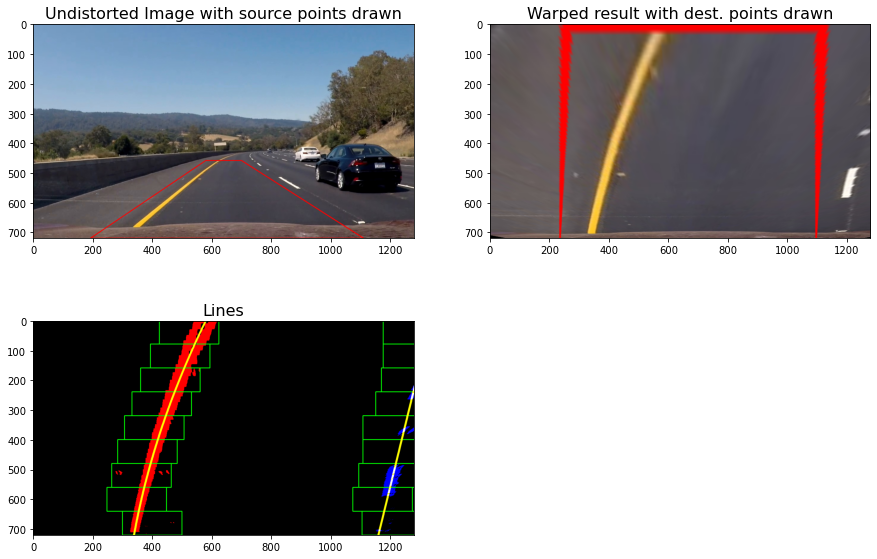

In [12]:
input_image_cp = input_image.copy()
cv2.polylines(input_image_cp,lane_finding.vertices,True,(255,0,0), 2)
warped_colored, _ = lane_finding.warp_perspective(input_image_cp)
out_img = lane_finding.draw_search_sliding(out_img, rects, ploty, leftx, lefty, rightx, righty,left_fitx, right_fitx )
images_list = [
    [input_image_cp, "Undistorted Image with source points drawn"],
    [warped_colored, "Warped result with dest. points drawn"],
    [out_img, "Lines"]
]

plot_images(images_list,is_binary=False, rows=2,columns=2, figsize=(15, 10))